##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Customizing a Transformer Encoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/nlp/customize_encoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/nlp/customize_encoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/nlp/customize_encoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/nlp/customize_encoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Learning objectives

The [TensorFlow Models NLP library](https://github.com/tensorflow/models/tree/master/official/nlp/modeling) is a collection of tools for building and training modern high performance natural language models.

The `tfm.nlp.networks.EncoderScaffold` is the core of this library, and lots of new network architectures are proposed to improve the encoder. In this Colab notebook, we will learn how to customize the encoder to employ new network architectures.

## Install and import

### Install the TensorFlow Model Garden pip package

*  `tf-models-official` is the stable Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` github repo. To include latest changes, you may install `tf-models-nightly`,
which is the nightly Model Garden package created daily automatically.
*  `pip` will install all models and dependencies automatically.

In [2]:
!pip install -q opencv-python

In [3]:
!pip install -q tf-models-official

### Import Tensorflow and other libraries

In [4]:
import numpy as np
import tensorflow as tf

import tensorflow_models as tfm
nlp = tfm.nlp

2023-12-14 12:09:32.926415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 12:09:32.926462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 12:09:32.927992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Canonical BERT encoder

Before learning how to customize the encoder, let's firstly create a canonical BERT enoder and use it to instantiate a `bert_classifier.BertClassifier` for classification task.

In [5]:
cfg = {
    "vocab_size": 100,
    "hidden_size": 32,
    "num_layers": 3,
    "num_attention_heads": 4,
    "intermediate_size": 64,
    "activation": tfm.utils.activations.gelu,
    "dropout_rate": 0.1,
    "attention_dropout_rate": 0.1,
    "max_sequence_length": 16,
    "type_vocab_size": 2,
    "initializer": tf.keras.initializers.TruncatedNormal(stddev=0.02),
}
bert_encoder = nlp.networks.BertEncoder(**cfg)

def build_classifier(bert_encoder):
  return nlp.models.BertClassifier(bert_encoder, num_classes=2)

canonical_classifier_model = build_classifier(bert_encoder)

`canonical_classifier_model` can be trained using the training data. For details about how to train the model, please see the [Fine tuning bert](https://www.tensorflow.org/text/tutorials/fine_tune_bert) notebook. We skip the code that trains the model here.

After training, we can apply the model to do prediction.


In [6]:
def predict(model):
  batch_size = 3
  np.random.seed(0)
  word_ids = np.random.randint(
      cfg["vocab_size"], size=(batch_size, cfg["max_sequence_length"]))
  mask = np.random.randint(2, size=(batch_size, cfg["max_sequence_length"]))
  type_ids = np.random.randint(
      cfg["type_vocab_size"], size=(batch_size, cfg["max_sequence_length"]))
  print(model([word_ids, mask, type_ids], training=False))

predict(canonical_classifier_model)

tf.Tensor(
[[ 0.03545166  0.30729884]
 [ 0.00677404  0.17251147]
 [-0.07276718  0.17345032]], shape=(3, 2), dtype=float32)


## Customize BERT encoder

One BERT encoder consists of an embedding network and multiple transformer blocks, and each transformer block contains an attention layer and a feedforward layer.

We provide easy ways to customize each of those components via (1)
[EncoderScaffold](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/networks/encoder_scaffold.py) and (2) [TransformerScaffold](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/transformer_scaffold.py).

### Use EncoderScaffold

`networks.EncoderScaffold` allows users to provide a custom embedding subnetwork
  (which will replace the standard embedding logic) and/or a custom hidden layer class (which will replace the `Transformer` instantiation in the encoder).

#### Without Customization

Without any customization, `networks.EncoderScaffold` behaves the same the canonical `networks.BertEncoder`.

As shown in the following example, `networks.EncoderScaffold` can load `networks.BertEncoder`'s weights and output the same values:

In [7]:
default_hidden_cfg = dict(
    num_attention_heads=cfg["num_attention_heads"],
    intermediate_size=cfg["intermediate_size"],
    intermediate_activation=cfg["activation"],
    dropout_rate=cfg["dropout_rate"],
    attention_dropout_rate=cfg["attention_dropout_rate"],
    kernel_initializer=cfg["initializer"],
)
default_embedding_cfg = dict(
    vocab_size=cfg["vocab_size"],
    type_vocab_size=cfg["type_vocab_size"],
    hidden_size=cfg["hidden_size"],
    initializer=cfg["initializer"],
    dropout_rate=cfg["dropout_rate"],
    max_seq_length=cfg["max_sequence_length"]
)
default_kwargs = dict(
    hidden_cfg=default_hidden_cfg,
    embedding_cfg=default_embedding_cfg,
    num_hidden_instances=cfg["num_layers"],
    pooled_output_dim=cfg["hidden_size"],
    return_all_layer_outputs=True,
    pooler_layer_initializer=cfg["initializer"],
)

encoder_scaffold = nlp.networks.EncoderScaffold(**default_kwargs)
classifier_model_from_encoder_scaffold = build_classifier(encoder_scaffold)
classifier_model_from_encoder_scaffold.set_weights(
    canonical_classifier_model.get_weights())
predict(classifier_model_from_encoder_scaffold)

tf.Tensor(
[[ 0.03545166  0.30729884]
 [ 0.00677404  0.17251147]
 [-0.07276718  0.17345032]], shape=(3, 2), dtype=float32)


#### Customize Embedding

Next, we show how to use a customized embedding network.

We first build an embedding network that would replace the default network. This one will have 2 inputs (`mask` and `word_ids`) instead of 3, and won't use positional embeddings.

In [8]:
word_ids = tf.keras.layers.Input(
    shape=(cfg['max_sequence_length'],), dtype=tf.int32, name="input_word_ids")
mask = tf.keras.layers.Input(
    shape=(cfg['max_sequence_length'],), dtype=tf.int32, name="input_mask")
embedding_layer = nlp.layers.OnDeviceEmbedding(
    vocab_size=cfg['vocab_size'],
    embedding_width=cfg['hidden_size'],
    initializer=cfg["initializer"],
    name="word_embeddings")
word_embeddings = embedding_layer(word_ids)
attention_mask = nlp.layers.SelfAttentionMask()([word_embeddings, mask])
new_embedding_network = tf.keras.Model([word_ids, mask],
                                       [word_embeddings, attention_mask])

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Inspecting `new_embedding_network`, we can see it takes two inputs:
`input_word_ids` and `input_mask`.

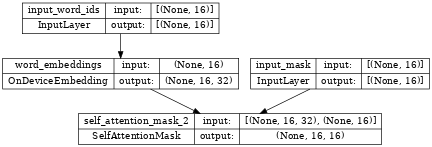

In [9]:
tf.keras.utils.plot_model(new_embedding_network, show_shapes=True, dpi=48)

We can then build a new encoder using the above `new_embedding_network`.

In [10]:
kwargs = dict(default_kwargs)

# Use new embedding network.
kwargs['embedding_cls'] = new_embedding_network
kwargs['embedding_data'] = embedding_layer.embeddings

encoder_with_customized_embedding = nlp.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder_with_customized_embedding)
# ... Train the model ...
print(classifier_model.inputs)

# Assert that there are only two inputs.
assert len(classifier_model.inputs) == 2

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


[<KerasTensor: shape=(None, 16) dtype=int32 (created by layer 'input_word_ids')>, <KerasTensor: shape=(None, 16) dtype=int32 (created by layer 'input_mask')>]


#### Customized Transformer

Users can also override the `hidden_cls` argument in `networks.EncoderScaffold`'s constructor employ a customized Transformer layer.

See [the source of `nlp.layers.ReZeroTransformer`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/rezero_transformer.py) for how to implement a customized Transformer layer.

The following is an example of using `nlp.layers.ReZeroTransformer`:


In [11]:
kwargs = dict(default_kwargs)

# Use ReZeroTransformer.
kwargs['hidden_cls'] = nlp.layers.ReZeroTransformer

encoder_with_rezero_transformer = nlp.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder_with_rezero_transformer)
# ... Train the model ...
predict(classifier_model)

# Assert that the variable `rezero_alpha` from ReZeroTransformer exists.
assert 'rezero_alpha' in ''.join([x.name for x in classifier_model.trainable_weights])

tf.Tensor(
[[-0.08663296  0.09281035]
 [-0.07291833  0.36477187]
 [-0.08730186  0.1503254 ]], shape=(3, 2), dtype=float32)


### Use `nlp.layers.TransformerScaffold`

The above method of customizing the model requires rewriting the whole `nlp.layers.Transformer` layer, while sometimes you may only want to customize either attention layer or feedforward block. In this case, `nlp.layers.TransformerScaffold` can be used.


#### Customize Attention Layer

User can also override the `attention_cls` argument in `layers.TransformerScaffold`'s constructor to employ a customized Attention layer.

See [the source of `nlp.layers.TalkingHeadsAttention`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/talking_heads_attention.py) for how to implement a customized `Attention` layer.

Following is an example of using `nlp.layers.TalkingHeadsAttention`:

In [12]:
# Use TalkingHeadsAttention
hidden_cfg = dict(default_hidden_cfg)
hidden_cfg['attention_cls'] = nlp.layers.TalkingHeadsAttention

kwargs = dict(default_kwargs)
kwargs['hidden_cls'] = nlp.layers.TransformerScaffold
kwargs['hidden_cfg'] = hidden_cfg

encoder = nlp.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder)
# ... Train the model ...
predict(classifier_model)

# Assert that the variable `pre_softmax_weight` from TalkingHeadsAttention exists.
assert 'pre_softmax_weight' in ''.join([x.name for x in classifier_model.trainable_weights])

tf.Tensor(
[[-0.20591784  0.09203205]
 [-0.0056177  -0.10278902]
 [-0.21681327 -0.12282   ]], shape=(3, 2), dtype=float32)


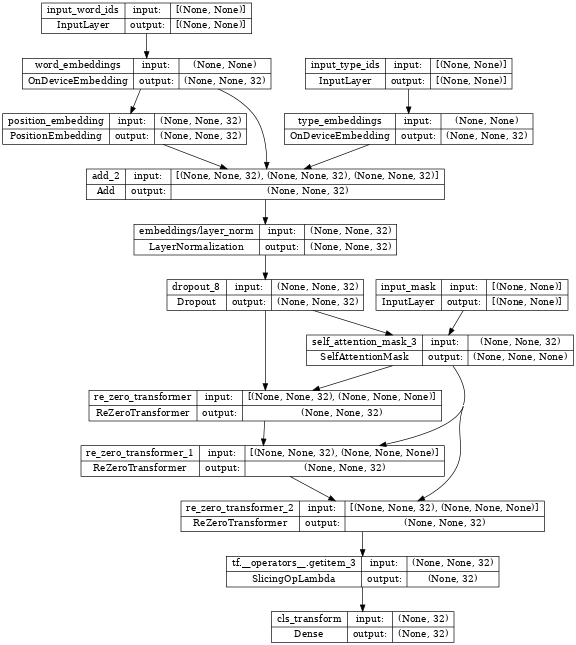

In [13]:
tf.keras.utils.plot_model(encoder_with_rezero_transformer, show_shapes=True, dpi=48)

#### Customize Feedforward Layer

Similiarly, one could also customize the feedforward layer.

See [the source of `nlp.layers.GatedFeedforward`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/gated_feedforward.py) for how to implement a customized feedforward layer.

Following is an example of using `nlp.layers.GatedFeedforward`:

In [14]:
# Use GatedFeedforward
hidden_cfg = dict(default_hidden_cfg)
hidden_cfg['feedforward_cls'] = nlp.layers.GatedFeedforward

kwargs = dict(default_kwargs)
kwargs['hidden_cls'] = nlp.layers.TransformerScaffold
kwargs['hidden_cfg'] = hidden_cfg

encoder_with_gated_feedforward = nlp.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder_with_gated_feedforward)
# ... Train the model ...
predict(classifier_model)

# Assert that the variable `gate` from GatedFeedforward exists.
assert 'gate' in ''.join([x.name for x in classifier_model.trainable_weights])

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


tf.Tensor(
[[-0.10270456 -0.10999684]
 [-0.03512481  0.15430304]
 [-0.23601504 -0.18162844]], shape=(3, 2), dtype=float32)


### Build a new Encoder

Finally, you could also build a new encoder using building blocks in the modeling library.

See [the source for `nlp.networks.AlbertEncoder`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/networks/albert_encoder.py) as an example of how to do this. 

Here is an example using `nlp.networks.AlbertEncoder`:


In [15]:
albert_encoder = nlp.networks.AlbertEncoder(**cfg)
classifier_model = build_classifier(albert_encoder)
# ... Train the model ...
predict(classifier_model)

tf.Tensor(
[[-0.00369881 -0.2540995 ]
 [ 0.1235221  -0.2959229 ]
 [-0.08698564 -0.17653546]], shape=(3, 2), dtype=float32)


Inspecting the `albert_encoder`, we see it stacks the same `Transformer` layer multiple times (note the loop-back on the "Transformer" block below..

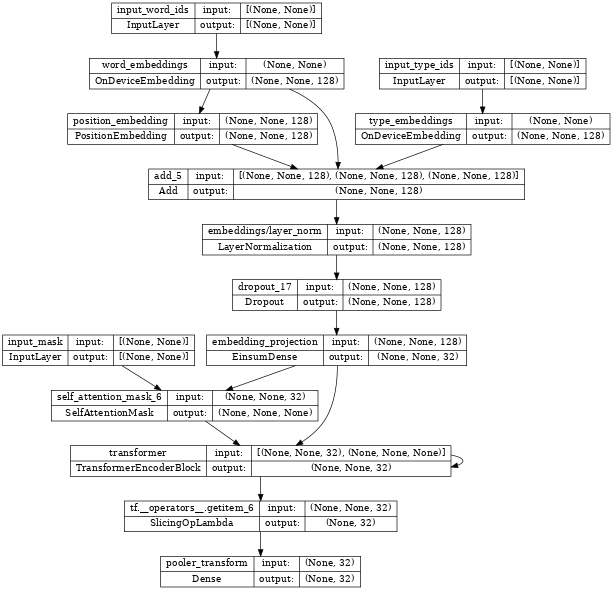

In [16]:
tf.keras.utils.plot_model(albert_encoder, show_shapes=True, dpi=48)